In [1]:
import numpy as np, pandas as pd, os, gc
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt, time
from itertools import repeat
from PIL import Image 
import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('../input/data-pre/new_data.csv')
train.head()

,ImageId,def1,def2,def3,def4,has_defect
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
1,00031f466.jpg,NaN,NaN,NaN,NaN,0
2,000418bfc.jpg,NaN,NaN,NaN,NaN,0
3,000789191.jpg,NaN,NaN,NaN,NaN,0
4,0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1


In [2]:
import keras
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/kaggle/input/severstal-steel-defect-detection/train_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train':
                    entry = self.df.iloc[indexes[i]]
                    y[i,:,:,0] = rle2maskResize(entry['def1'])
                    y[i,:,:,1] = rle2maskResize(entry['def2'])
                    y[i,:,:,2] = rle2maskResize(entry['def3'])
                    y[i,:,:,3] = rle2maskResize(entry['def4'])
                    
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

In [3]:
def rle2maskResize(mask_rle):
    #Returns numpy array, 1 - mask, 0 - background
    if mask_rle=='' or pd.isnull(mask_rle):
        return np.zeros((128,800),dtype=np.uint8)
    s = mask_rle.split() #s will be of the format [starting index length starting index length.....]
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])] #starts : list of staring indices and lengths : lengths of each component
    starts -= 1 #convert to zero indexing
    ends = starts + lengths #ending pixels
    img = np.zeros(256*1600, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(1600,256).T[::2,::2]

In [4]:
! pip install segmentation-models
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

     |████████████████████████████████| 50 kB 2.0 MB/s            
Segmentation Models: using `keras` framework.


'tf.keras'

In [5]:
from keras import backend as K
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

In [6]:
from segmentation_models.utils import set_trainable
preprocess = sm.get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
model = sm.Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid',encoder_weights='imagenet',encoder_freeze=True)#transfer learning,#freeze encoders
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

# TRAIN AND VALIDATE MODEL
idx1 = int(0.6*len(train));print()
idx2 = int(0.8*len(train));print()
train_batches = DataGenerator(train.iloc[:idx1],shuffle=True,preprocess=preprocess)
valid_batches = DataGenerator(train.iloc[idx1:idx2],preprocess=preprocess)

#train decoder weights inorder to avoid the decoder from affecting the per-trained encoder for 3 epochs
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 2, verbose=1)
set_trainable(model, recompile=False)
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=1)

2021-12-04 10:15:51.937470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 10:15:52.026142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 10:15:52.027092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 10:15:52.028720: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

85532672/85521592 [==============================] - 2s 0us/step




2021-12-04 10:15:58.684026: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2021-12-04 10:16:03.790120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


471/471 [==============================] - 236s 477ms/step - loss: 0.0642 - dice_coef: 0.1919 - val_loss: 0.0267 - val_dice_coef: 0.3770
Epoch 2/2
471/471 [==============================] - 167s 355ms/step - loss: 0.0185 - dice_coef: 0.3687 - val_loss: 0.0222 - val_dice_coef: 0.3375
Epoch 1/30
471/471 [==============================] - 167s 354ms/step - loss: 0.0157 - dice_coef: 0.4454 - val_loss: 0.0167 - val_dice_coef: 0.5186
Epoch 2/30
471/471 [==============================] - 168s 357ms/step - loss: 0.0143 - dice_coef: 0.4819 - val_loss: 0.0160 - val_dice_coef: 0.5610
Epoch 3/30
471/471 [==============================] - 169s 359ms/step - loss: 0.0139 - dice_coef: 0.4900 - val_loss: 0.0174 - val_dice_coef: 0.4552
Epoch 4/30
471/471 [==============================] - 172s 366ms/step - loss: 0.0128 - dice_coef: 0.5206 - val_loss: 0.0143 - val_dice_coef: 0.5348
Epoch 5/30
471/471 [==============================] - 171s 362ms/step - loss: 0.0121 - dice_coef: 0.5448 - val_loss: 0.0137 

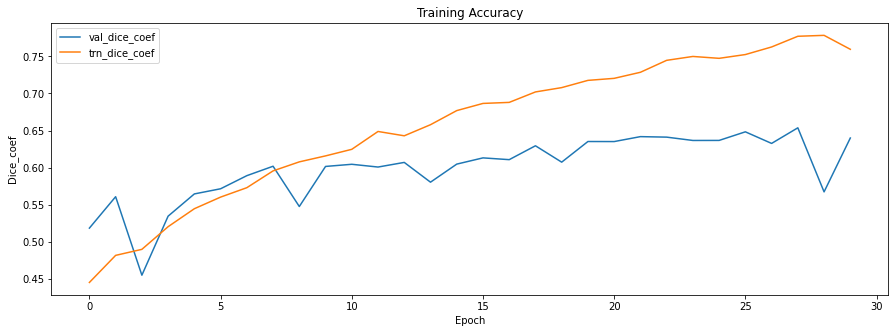

In [7]:
model.save('UNET.h5')
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()